### This is the code to grid search some parameters to create a GRU model
#### References:
- Peixeiro, M. (2022). Time series forecasting in Python. Manning. Includes the codes fromi its GitHub repo (https://github.com/marcopeix/AppliedTimeSeriesForecastingInPython). Contribution: The technique for converting the series into sequenced samples and the idea for scale and reeschale data after predictions.
- Discolll, N. (2024, January 12). Harnessing RNNs for Financial Time Series Analysis: A Python Approach. Medium. https://medium.com/@redeaddiscolll/harnessing-rnns-for-financial-time-series-analysis-a-python-approach-0669b3a25c7a. Contribution: EarlyStopping function.

#### Packages
- Package Pandas (2.2). (2024). [Python]. https://pandas.pydata.org/
- Package NumPy (1.23). (2023). [Pyhton]. https://numpy.org/ - Harris, C. R., Millman, K. J., Van Der Walt, S. J., Gommers, R., Virtanen, P., Cournapeau, D., Wieser, E., Taylor, J., Berg, S., Smith, N. J., Kern, R., Picus, M., Hoyer, S., Van Kerkwijk, M. H., Brett, M., Haldane, A., Del Río, J. F., Wiebe, M., Peterson, P., … Oliphant, T. E. (2020). Array programming with NumPy. Nature, 585(7825), 357–362. https://doi.org/10.1038/s41586-020-2649-2
- Droettboom, J. D. H., Michael. (2024). Package matplotlib (3.8.4) [Python]. https://matplotlib.org
- Package scikit-learn (1.4). (2024). [Pyhton]. https://scikit-learn.org/stable/index.html
- Package Tensorflow (2.16). (2024). [Python]. https://github.com/tensorflow

In [144]:
# Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random as python_random

from tensorflow.random import set_seed
import useful_functions as uf
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import ParameterGrid
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import GRU, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.regularizers import l1_l2

In [134]:
# load the data
#file_path = '../data/data_orig_parameters.csv'
#file_path = '../data/BR_param_EDA.csv'
#file_path = '../data/data_cleaned_RF.csv'
file_path = '../data/data_cleaned_LASSO.csv'
#file_path = '../data/data_cleaned_RFE.csv'

# parse the date column and set it as the index of the dataframe
df_raw = pd.read_csv(file_path, parse_dates=['Date'], index_col='Date')

# define the target variable as the first column
target_variable = df_raw.columns[0]

# Convert all columns to float
df_raw = df_raw.astype('float64')

# Define a threshold to remove outliers
remove_outliers_threshold = np.nan # No outliers removed
#remove_outliers_threshold = 0.20

In [135]:
# Remove outliers based on the threshold
if not pd.isna(remove_outliers_threshold): # If the threshold is not NaN, remove outliers
    df_cleaned = uf.remove_outliers(df_raw.copy(), threshold=remove_outliers_threshold)
else: # Otherwise, keep the original dataframe
    df_cleaned = df_raw.copy()

# Given outliers were removed, fill missing values
df_adjusted = uf.fill_missing_values(df_cleaned)

In [137]:
# Define test and validation set sizes
val_size = 48 # 48 months or 4 years
test_size = 48 # 48 months or 4 years

# Split the data into train and test sets
train_raw_total = df_adjusted.copy()[:-test_size] # This total trainning set will be used to train the final model
train_raw = train_raw_total[:-val_size]
val_raw = train_raw_total[-val_size:]
test_raw = df_adjusted.copy()[-test_size:]

# Fill missing values
df_train = uf.fill_missing_values(train_raw)
df_val = uf.fill_missing_values(val_raw)
df_test = uf.fill_missing_values(test_raw)


In [138]:
# Let´s scale the dfs
# Create a scaler
scaler = MinMaxScaler(feature_range=(0,1))
scaled_train = scaler.fit_transform(df_train) # Fit and transform the train set
scaled_val = scaler.transform(df_val) # Transform the validation set
scaled_test = scaler.transform(df_test) # Transform the test set

# include df columns names in the train and test sets
train = pd.DataFrame(scaled_train, columns=df_train.columns)
val = pd.DataFrame(scaled_val, columns=df_val.columns)
test = pd.DataFrame(scaled_test, columns=df_test.columns)

# Include the index in the train and test sets
train.index = df_train.index
val.index = df_val.index
test.index = df_test.index


Reshape your data

In [139]:
# Converting the series to samples
# We will use the past 12 months to predict a month 12 months in the future
def createXY(dataset, n_past, n_future):
    dataX, dataY = [], []
    # Loop for the entire dataset
    for i in range(n_past, len(dataset) - n_future + 1):
        dataX.append(dataset.iloc[i - n_past:i].values)  # Past n months
        dataY.append(dataset.iloc[i + n_future - 1, 0])  #
    return np.array(dataX), np.array(dataY)

n_past = 12  # Number of past months to use
n_future = 12  # Forecast horizon

# Create the samples
X_train, Y_train = createXY(train, n_past, n_future)
X_val, Y_val = createXY(val, n_past, n_future)
X_test, Y_test = createXY(test, n_past, n_future)


### Let's grid to find the best parameters

In [145]:
# Let's define the seed for reproducibility

def func_set_seed(seed=42):
    np.random.seed(seed)
    python_random.seed(seed)
    set_seed(seed) #tensorflow.random.set_seed(seed)

# Call the function to set the seed
func_set_seed(42)


In [146]:
### Build a GRU model testing different parameters

# Function to build the model
def build_model(n_layers = 2,  # Number of hidden layers
                optimizer='adam',  # Optimizer
                learning_rate=0.001,  # Learning rate for the optimizer
                gru_units={0: 50,  1: 20, 2: 10}, # Number of units in the GRU layers
                #alphas_l1_l2=0.01, # Removed regularization for now, because it was not improving the model
                dropout_rate=0.1 # Dropout rate to avoid overfitting
                ):
    
    # Check the optimizer
    if optimizer == 'adam':
        optimizer = Adam(learning_rate=learning_rate)
    elif optimizer == 'rmsprop':
        optimizer = RMSprop(learning_rate=learning_rate)
    
    # Create the model
    model = Sequential()
    # Define the input layer shape
    model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))
    # Add the GRU layers
    for i in range(n_layers):
        if i < n_layers - 1:  # intermediate hidden layers
            model.add(GRU(units=gru_units[i+1],
                                # Removed regularization for now, because it was not improving the model
                                #kernel_regularizer=l1_l2(l1=alphas_l1_l2, l2=alphas_l1_l2), 
                                #recurrent_regularizer=l1_l2(l1=alphas_l1_l2, l2=alphas_l1_l2),
                                #bias_regularizer=l1_l2(l1=alphas_l1_l2, l2=alphas_l1_l2),
                                return_sequences=True))
            model.add(Dropout(dropout_rate))
        else:  # last hidden layer
            model.add(GRU(units=gru_units[i+1],
                                # Removed regularization for now, because it was not improving the model
                                #kernel_regularizer=l1_l2(l1=alphas_l1_l2, l2=alphas_l1_l2), 
                                #recurrent_regularizer=l1_l2(l1=alphas_l1_l2, l2=alphas_l1_l2),
                                #bias_regularizer=l1_l2(l1=alphas_l1_l2, l2=alphas_l1_l2)))
                                return_sequences=False))
            model.add(Dropout(dropout_rate))
    model.add(Dense(units=1)) #output layer
    # Compile the model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# Function to test each set of parameters
def custom_fit(params):
    # Get the parameters to train the model
    training_params = {key: params[key] for key in params if key in ['n_layers', 
                                                                     #'alphas_l1_l2',# Removed regularization for now, because it was not improving the model
                                                                     'dropout_rate',
                                                                     'gru_units', 
                                                                     'optimizer', 
                                                                     'learning_rate']}
    model = build_model(**training_params) # Create the model
    
    # Define EarlyStopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True) # Stop training when the validation loss is no longer decreasing after X epochs

    # Fitting the model with early stopping
    model.fit(X_train, Y_train, 
              epochs=params['epochs'], 
              batch_size=params['batch_size'], 
              verbose=0,
              validation_data=(X_val, Y_val), 
              callbacks=[early_stopping])
    
    # Compute the loss on the validation set to compare the models
    loss = model.evaluate(X_val, Y_val, verbose=0)
    return loss

# Parameters to test
param_grid = {
    'dropout_rate': [0.1, 0.2],
    #'alphas_l1_l2' : [0.001, 0.01, 0.1, 1],
    'batch_size': [32, 64],
    'epochs': [30, 50, 75],
    'optimizer': ['adam', 'rmsprop'],
    'learning_rate': [0.001, 0.0001], # Learning rate
    'n_layers': [1,2,3], # Number of hidden layers
    'gru_units' : [{1: 10,  2: 10, 3: 5}, {1: 50,  2: 30, 3: 15},
                   {1: 100,  2: 100, 3: 50}, {1: 200,  2: 200, 3: 100}]  
}

# Compare the scores for each set of parameters
best_score = np.inf
best_params = None
interactions = 1
# Loop through all the parameters in the grid
for params in ParameterGrid(param_grid): # For each set of parameters
    print("Applying parameters: ", params,". This is the ", interactions, "th iteration")
    interactions += 1
    score = custom_fit(params) # Train the model and get the score
    if score < best_score: # If the score is better than the best score
        best_score = score # Update the best score
        best_params = params # Update the best parameters

# Print the best score and best parameters
print(f'Best Score: {best_score}')
print(f'Best Parameters: {best_params}')

Applying parameters:  {'batch_size': 32, 'dropout_rate': 0.1, 'epochs': 30, 'gru_units': {1: 10, 2: 10, 3: 5}, 'learning_rate': 0.001, 'n_layers': 1, 'optimizer': 'adam'} . This is the  1 th iteration
Applying parameters:  {'batch_size': 32, 'dropout_rate': 0.1, 'epochs': 30, 'gru_units': {1: 10, 2: 10, 3: 5}, 'learning_rate': 0.001, 'n_layers': 1, 'optimizer': 'rmsprop'} . This is the  2 th iteration
Applying parameters:  {'batch_size': 32, 'dropout_rate': 0.1, 'epochs': 30, 'gru_units': {1: 10, 2: 10, 3: 5}, 'learning_rate': 0.001, 'n_layers': 2, 'optimizer': 'adam'} . This is the  3 th iteration
Applying parameters:  {'batch_size': 32, 'dropout_rate': 0.1, 'epochs': 30, 'gru_units': {1: 10, 2: 10, 3: 5}, 'learning_rate': 0.001, 'n_layers': 2, 'optimizer': 'rmsprop'} . This is the  4 th iteration
Applying parameters:  {'batch_size': 32, 'dropout_rate': 0.1, 'epochs': 30, 'gru_units': {1: 10, 2: 10, 3: 5}, 'learning_rate': 0.001, 'n_layers': 3, 'optimizer': 'adam'} . This is the  5 th

In [147]:
# Now let's build the model with the best parameters and train it
# Get epochs and batch_size from best_params
best_params_bkp = best_params.copy()
epochs = best_params.pop('epochs')
batch_size = best_params.pop('batch_size')

# build the model
best_model_GRU = build_model(**best_params)

In [148]:
# Save the best model - Adjust the file name based on the used dataset and patience
best_model_GRU.save('models_parameters/best_gru_model_grid_lasso_10.keras')  # Saves the model to a keras file

In [ ]:
# If we need to restore the best model

# # Load the model from the file
# best_model = load_model('best_gru_model_grid.keras')
# # from manual hyperparameter tuning
# epochs = 20
# batch_size = 32

In [149]:
# train the model
history = best_model_GRU.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=epochs, batch_size=batch_size, verbose=2)

# Make predictions
predictions_scaled = best_model_GRU.predict(X_val)

Epoch 1/75


5/5 - 4s - 739ms/step - loss: 0.3491 - val_loss: 0.0695
Epoch 2/75
5/5 - 0s - 37ms/step - loss: 0.0257 - val_loss: 0.0623
Epoch 3/75
5/5 - 0s - 29ms/step - loss: 0.0209 - val_loss: 0.0429
Epoch 4/75
5/5 - 0s - 70ms/step - loss: 0.0339 - val_loss: 0.1426
Epoch 5/75
5/5 - 0s - 51ms/step - loss: 0.0735 - val_loss: 0.0704
Epoch 6/75
5/5 - 0s - 39ms/step - loss: 0.0339 - val_loss: 0.0433
Epoch 7/75
5/5 - 0s - 64ms/step - loss: 0.0258 - val_loss: 0.0699
Epoch 8/75
5/5 - 0s - 76ms/step - loss: 0.0709 - val_loss: 0.1163
Epoch 9/75
5/5 - 0s - 68ms/step - loss: 0.0407 - val_loss: 0.0476
Epoch 10/75
5/5 - 0s - 32ms/step - loss: 0.0193 - val_loss: 0.0517
Epoch 11/75
5/5 - 0s - 32ms/step - loss: 0.0313 - val_loss: 0.0604
Epoch 12/75
5/5 - 0s - 40ms/step - loss: 0.0372 - val_loss: 0.1278
Epoch 13/75
5/5 - 0s - 37ms/step - loss: 0.0368 - val_loss: 0.0392
Epoch 14/75
5/5 - 0s - 66ms/step - loss: 0.0153 - val_loss: 0.0418
Epoch 15/75
5/5 - 0s - 31ms/step - loss: 0.0451 - val_loss: 0.0781
Epoch 16/75
5/

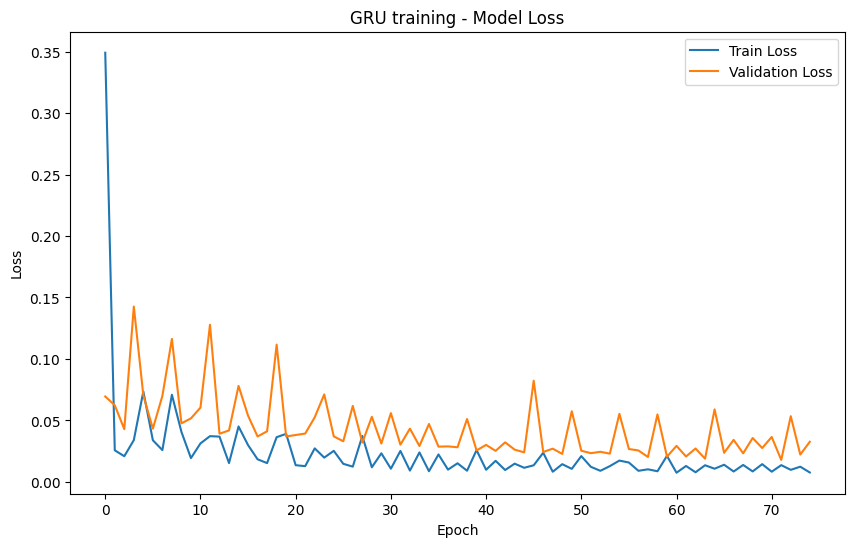

In [150]:
# Plot training & validation loss values
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('GRU training - Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

In [151]:
# Let's reshape the predictions and Y_val to revert the scaling
# Reshape predictions to 2D
predictions_scaled_2d = predictions_scaled.reshape(-1, 1)

# Get the last timestep of X_val
X_val_last_timestep = X_val[:, -1, :]

# Replace the first column of X_val_last_timestep with the scaled predictions.
X_val_last_timestep[:, 0] = predictions_scaled_2d[:, 0]

# unscale the predictions
predictions_rescaled = scaler.inverse_transform(X_val_last_timestep)[:, 0]

# unscale the Y_val
Y_val_rescaled = scaler.inverse_transform(val.iloc[-len(predictions_scaled):, :].values)[:, 0]

# Calculate the error
mape_GRU_val = mean_absolute_percentage_error(Y_val_rescaled, predictions_rescaled)
rmse_GRU_val = np.sqrt(mean_squared_error(Y_val_rescaled, predictions_rescaled))
mae_GRU_val = mean_absolute_error(Y_val_rescaled, predictions_rescaled)

print(f'MAPE GRU: {mape_GRU_val}')
print(f'RMSE GRU: {rmse_GRU_val}')
print(f'MAE GRU: {mae_GRU_val}')

MAPE GRU: 1.5237139463424683
RMSE GRU: 16173.380859375
MAE GRU: 12631.37109375


### Predictions on the test set

In [153]:
# Let's predict the test set using the best model
predictions_test_scaled = best_model_GRU.predict(X_test)

# Let's reshape the predictions and Y_val to revert the scaling
# Reshape predictions to 2D
predictions_test_scaled_2d = predictions_test_scaled.reshape(-1, 1)

# Get the last timestep of X_test
X_test_last_timestep = X_test[:, -1, :]

# Replace the first column of X_test_last_timestep with the scaled predictions.
X_test_last_timestep[:, 0] = predictions_test_scaled_2d[:, 0]

# unscale the predictions
predictions_test_rescaled = scaler.inverse_transform(X_test_last_timestep)[:, 0]

# Let's convert the predictions and Y_test to a dataframe usind the index from test
predictions_test_df = pd.DataFrame(predictions_test_rescaled, index=test.index[-len(predictions_test_rescaled):], columns=[target_variable])
predictions = predictions_test_df.copy()

# Get the original Y_test values to compare
Y_test = df_adjusted[-len(predictions):][target_variable]


In [154]:
# Calculate the error
mape_best_GRU = mean_absolute_percentage_error(Y_test, predictions)
rmse_best_GRU = np.sqrt(mean_squared_error(Y_test, predictions))
mae_best_GRU = mean_absolute_error(Y_test, predictions)

print(f'MAPE best GRU: {mape_best_GRU}')
print(f'RMSE best GRU: {rmse_best_GRU}')
print(f'MAE best GRU: {mae_best_GRU}')

MAPE best GRU: 2.0594608783721924
RMSE best GRU: 51260.19140625
MAE best GRU: 39458.93359375


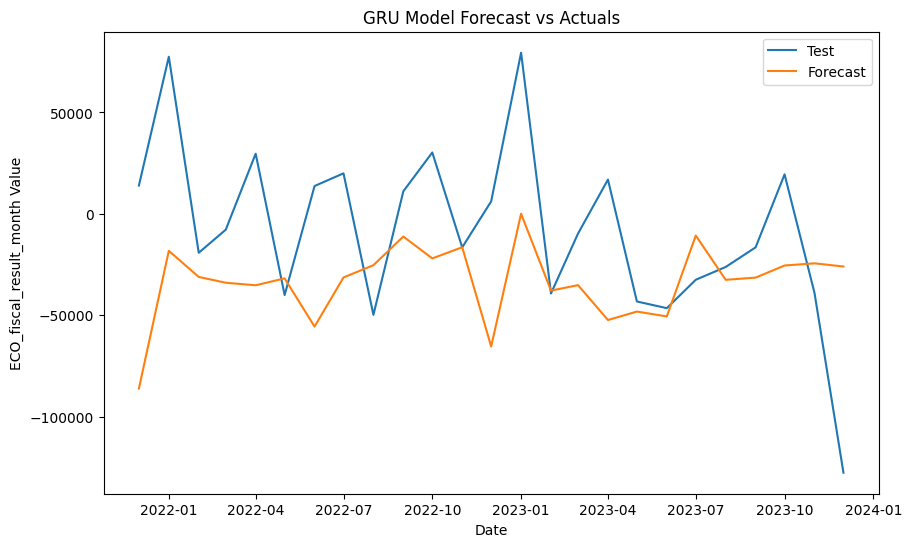

In [155]:
# Plot GRU best Model Predictions vs Actuals - test Set

# Convert Y_test_rescaled to a dataframe using the test index
Y_test_rescaled_df = pd.DataFrame(Y_test, index=Y_test.index)

# Change the column name to the target variable
Y_test_rescaled_df.columns = [target_variable]

uf.plot_forecast_vs_test(
    target_variable, 
    Y_test_rescaled_df[target_variable],
    predictions,
    'GRU Model Predictions vs Actuals - Test Set',)